In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

c:\Users\jimmy\anaconda3\envs\stock\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_path = './data/train.csv'
df = pd.read_csv(data_path)
df['10_trend'] = df['10_trend'].map({-1: 0, 0: 1, 1: 2})

In [20]:
def create_lagged_features(df, days=30):
    features = []
    targets = []

    for i in tqdm(range(days-1, len(df))):
        feature_row = []
        target = df.iloc[i]['10_trend']

        # 過去days天的數據
        for j in range(days-1, -1, -1):
            feature_row.extend([
                df.iloc[i - j]['close'],
                df.iloc[i - j]['open'],
                df.iloc[i - j]['high'],
                df.iloc[i - j]['low'],
                df.iloc[i - j]['volume']
            ])
        features.append(feature_row)
        targets.append(target)

    return np.array(features), np.array(targets)

In [56]:
# 3. 創建特徵和標籤
features, targets = create_lagged_features(df, days=30)

# 4. 分割數據集
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# 5. 數據標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. 調整數據形狀
X_train = X_train.reshape(X_train.shape[0], 30, 5)  # 確保這裡形狀是 (N, 30, 5)
X_test = X_test.reshape(X_test.shape[0], 30, 5)

# 轉為 PyTorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # 分類問題需要 long 類型
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


100%|██████████| 1833/1833 [00:33<00:00, 54.90it/s]


In [48]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=5, hidden_size=100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
        self.fc = nn.Linear(100 * 2, 3)  # 雙向的LSTM
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return torch.softmax(x, dim=1)  # 獲得概率分布


In [57]:
# 8. 初始化模型、損失函數和優化器
model = LSTM()
class_weights = torch.tensor([1.0, 5.0, 1.0], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(class_weights)  # 使用交叉熵損失
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# 9. 訓練模型
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    predicted_classes = torch.argmax(output, dim=1)  # 獲取預測的類別
    accuracy = accuracy_score(y_train_tensor.numpy(), predicted_classes.numpy())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
    model.eval()
    with torch.no_grad():
        val_output = model(X_test_tensor)  # 使用驗證集進行預測
        val_predicted_classes = torch.argmax(val_output, dim=1)
        val_accuracy = accuracy_score(y_test_tensor.numpy(), val_predicted_classes.numpy())

        predictions = model(X_test_tensor)
        predicted_classes = torch.argmax(predictions, dim=1)
        class_mapping = {0: -1, 1: 0, 2: 1}
        mapped_predictions = np.array([class_mapping[pred.item()] for pred in predicted_classes])
        y_test_mapped = y_test_tensor.numpy()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Validation Accuracy: {val_accuracy:.4f}')

report = classification_report(y_test_mapped, mapped_predictions, target_names=['0', '1', '2'], labels=[0, 1, 2])
print(report)



Epoch [10/100], Loss: 1.0800, Accuracy: 0.1733
Epoch [10/100], Validation Accuracy: 0.1417
Epoch [20/100], Loss: 1.0683, Accuracy: 0.2046
Epoch [20/100], Validation Accuracy: 0.1826
Epoch [30/100], Loss: 1.0599, Accuracy: 0.2476
Epoch [30/100], Validation Accuracy: 0.2643
Epoch [40/100], Loss: 1.0473, Accuracy: 0.2647
Epoch [40/100], Validation Accuracy: 0.2398
Epoch [50/100], Loss: 1.0465, Accuracy: 0.3547
Epoch [50/100], Validation Accuracy: 0.3488
Epoch [60/100], Loss: 1.0392, Accuracy: 0.3704
Epoch [60/100], Validation Accuracy: 0.4060
Epoch [70/100], Loss: 1.0367, Accuracy: 0.4065
Epoch [70/100], Validation Accuracy: 0.4087
Epoch [80/100], Loss: 1.0288, Accuracy: 0.3922
Epoch [80/100], Validation Accuracy: 0.3733
Epoch [90/100], Loss: 1.0196, Accuracy: 0.4018
Epoch [90/100], Validation Accuracy: 0.3924
Epoch [100/100], Loss: 1.0167, Accuracy: 0.4134
Epoch [100/100], Validation Accuracy: 0.4060
              precision    recall  f1-score   support

           0       0.35      0.46

c:\Users\jimmy\anaconda3\envs\stock\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jimmy\anaconda3\envs\stock\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jimmy\anaconda3\envs\stock\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
def create_test_features(df, days=30):
    
    features = []
    for i in tqdm(range(days-1, len(df)+1, days)):
        feature_row = []

        for j in range(days-1, -1, -1):
            feature_row.extend([
                df.iloc[i - j]['close'],
                df.iloc[i - j]['open'],
                df.iloc[i - j]['high'],
                df.iloc[i - j]['low'],
                df.iloc[i - j]['volume']
            ])

        features.append(feature_row)
    
    return np.array(features)

In [59]:
# 1. 讀取測試數據
test_data_path = './data/test.csv'
test_df = pd.read_csv(test_data_path)

# 2. 使用滯後特徵生成函數創建測試特徵
features_test = create_test_features(test_df, days=30)

# 3. 標準化測試特徵
features_test = scaler.transform(features_test)

# 4. 調整測試數據形狀
features_test = features_test.reshape(features_test.shape[0], 30, 5)

# 5. 轉換為 PyTorch tensor
X_test_tensor_test = torch.tensor(features_test, dtype=torch.float32)

# 6. 使用訓練好的模型進行預測
model.eval()  # 切換到評估模式
with torch.no_grad():
    test_predictions = model(X_test_tensor_test)

# 7. 將預測從 logits 轉為類別
predicted_classes = torch.argmax(test_predictions, dim=1).numpy()

# 8. 將 0, 1, 2 映射回 -1, 0, 1
class_mapping = {0: -1, 1: 0, 2: 1}
mapped_predictions = np.array([class_mapping[pred] for pred in predicted_classes])

# 9. 保存預測結果到 CSV
output_test_df = pd.DataFrame({
    'id': test_df['date'][-len(mapped_predictions):],
    'trend': mapped_predictions
})
output_test_df.to_csv('test_predictions_3.csv', index=False)

100%|██████████| 427/427 [00:07<00:00, 57.77it/s]


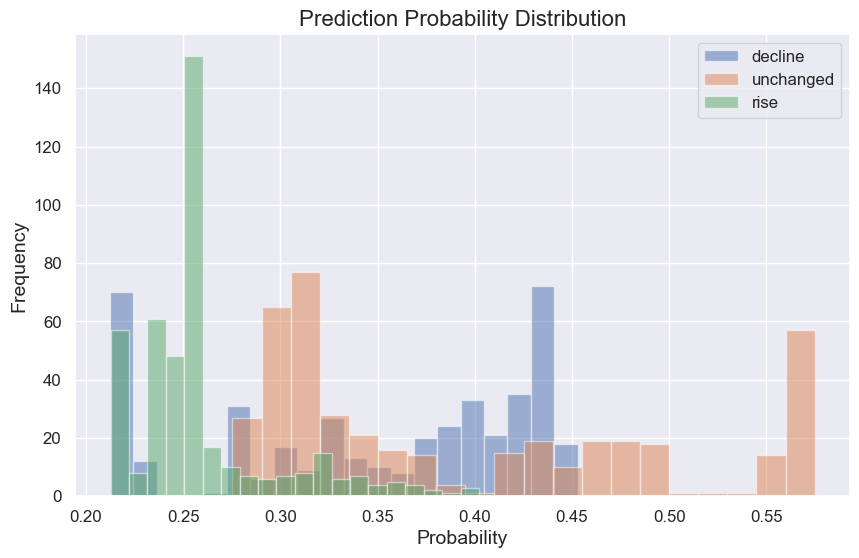

In [60]:

# 假設 model 有 predict_proba 方法，否則使用 softmax
# prob_1_trend = model.predict_proba(X_val_tensor.numpy())
with torch.no_grad():
    logits = model(X_test_tensor_test)
    prob_1_trend = torch.softmax(logits, dim=1).numpy()  # 獲取預測的概率

# 繪製預測概率分佈圖
class_map = {-1: "decline", 0: "unchanged", 1: "rise"}
class_order = [class_map[-1], class_map[0], class_map[1]]

plt.figure(figsize=(10, 6))

for i in range(prob_1_trend.shape[1]):
    plt.hist(prob_1_trend[:, i], bins=20, alpha=0.5, label=class_order[i])

plt.title('Prediction Probability Distribution', fontsize=16)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.show()

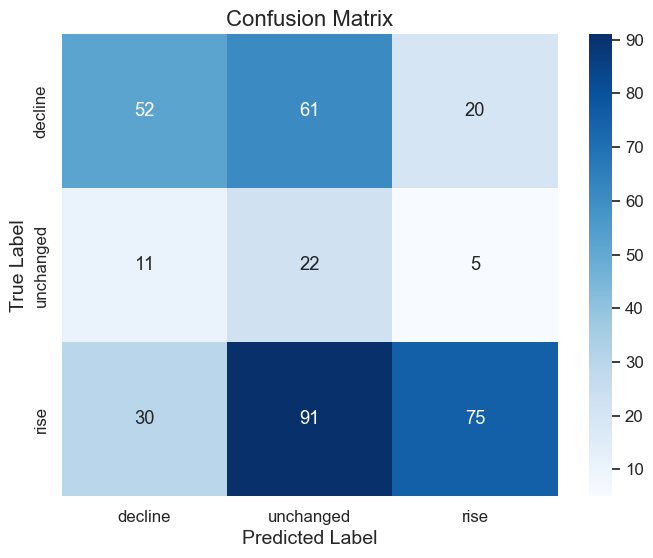

In [61]:

# 計算混淆矩陣
y_pred = torch.argmax(predictions, dim=1).numpy()  # 從模型的預測中獲取預測類別
cm = confusion_matrix(y_test_tensor.numpy(), y_pred)  # 使用真實標籤和預測標籤計算混淆矩陣

# 繪製混淆矩陣
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['decline', 'unchanged', 'rise'], 
            yticklabels=['decline', 'unchanged', 'rise'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()


In [136]:
# 讀取三個 CSV 檔案
df1 = pd.read_csv('./test_predictions_1.csv')
df2 = pd.read_csv('./test_predictions_2.csv')
df3 = pd.read_csv('./test_predictions_3.csv')

# 合併三個 DataFrame，這裡使用 concat() 進行縱向合併
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# 保存合併後的 DataFrame 到新的 CSV 檔案
merged_df.to_csv('output.csv', index=False)

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu
